[Epoch 0/400] [Batch 0/3] [D loss: 0.7309] [G loss: 2.1044]
[Epoch 1/400] [Batch 0/3] [D loss: 1.6793] [G loss: 1.3828]
[Epoch 2/400] [Batch 0/3] [D loss: 1.2001] [G loss: 1.8519]
[Epoch 3/400] [Batch 0/3] [D loss: 1.0028] [G loss: 1.8672]
[Epoch 4/400] [Batch 0/3] [D loss: 0.9777] [G loss: 1.7543]
[Epoch 5/400] [Batch 0/3] [D loss: 0.9406] [G loss: 1.7088]
[Epoch 6/400] [Batch 0/3] [D loss: 0.9020] [G loss: 1.6765]
[Epoch 7/400] [Batch 0/3] [D loss: 0.8978] [G loss: 1.5431]
[Epoch 8/400] [Batch 0/3] [D loss: 0.8858] [G loss: 1.4594]
[Epoch 9/400] [Batch 0/3] [D loss: 0.8519] [G loss: 1.4864]
[Epoch 10/400] [Batch 0/3] [D loss: 0.8176] [G loss: 1.4426]
[Epoch 11/400] [Batch 0/3] [D loss: 0.8403] [G loss: 1.2306]
[Epoch 12/400] [Batch 0/3] [D loss: 0.8088] [G loss: 1.4096]
[Epoch 13/400] [Batch 0/3] [D loss: 0.8245] [G loss: 1.3816]
[Epoch 14/400] [Batch 0/3] [D loss: 0.8034] [G loss: 1.3846]
[Epoch 15/400] [Batch 0/3] [D loss: 0.7520] [G loss: 1.3177]
[Epoch 16/400] [Batch 0/3] [D loss

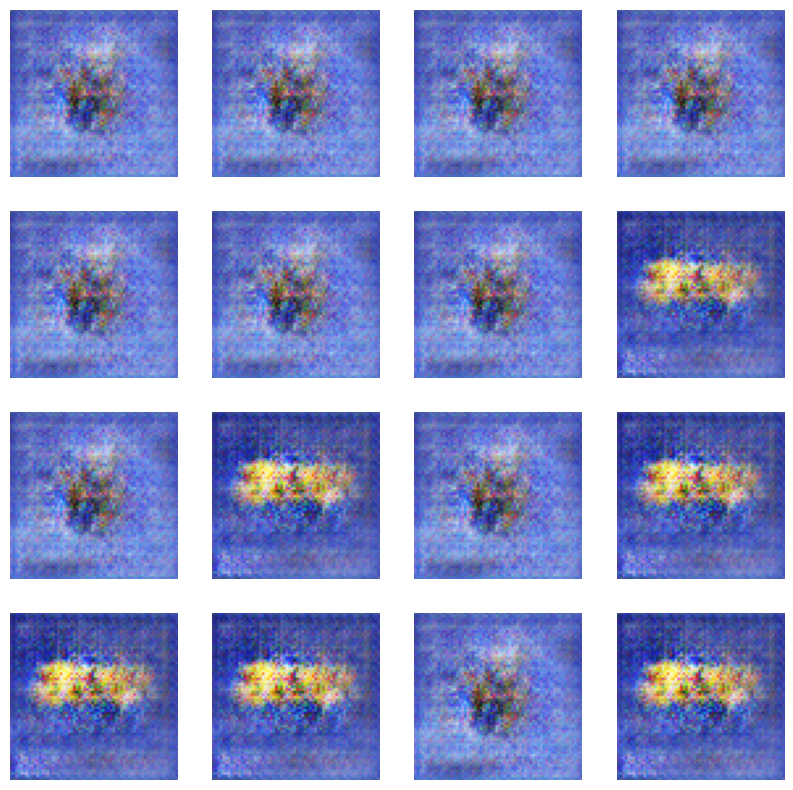

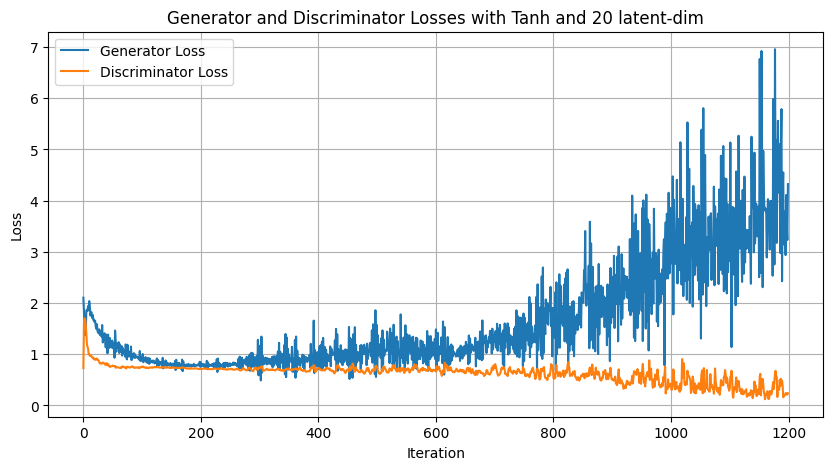

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, channels):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.main = nn.Sequential(
            # input is Z + label embedding, going into a convolution
            nn.ConvTranspose2d(latent_dim * 2, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. channels x 64 x 64
        )

    def forward(self, input, labels):
        label_embedding = self.label_embedding(labels).view(-1, latent_dim, 1, 1)
        gen_input = torch.cat((input, label_embedding), dim=1)
        return self.main(gen_input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, num_classes, channels):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, channels * 64 * 64)
        self.main = nn.Sequential(
            # input is channels + label embedding x 64 x 64
            nn.Conv2d(channels * 2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        label_embedding = self.label_embedding(labels).view(-1, channels, 64, 64)
        d_input = torch.cat((input, label_embedding), dim=1)
        return self.main(d_input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
num_classes = len(train_dataset.classes)  # Number of classes in the dataset
channels = 3  # RGB images

generator = Generator(latent_dim, num_classes, channels).to(device)
discriminator = Discriminator(num_classes, channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 400
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples
fixed_labels = torch.randint(0, num_classes, (64,), device=device)  # Fixed labels for visualization

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z, labels).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images, labels), valid)
        fake_loss = criterion(discriminator(fake_images, labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z, labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images, labels), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise, fixed_labels).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with Tanh and 20 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

Classes found: {'Cow': 0, 'Horse': 1}
Epoch 1/200 | G Loss: 6.4799 | D Loss: 1.2399
Epoch 2/200 | G Loss: 5.3935 | D Loss: 1.2081
Epoch 3/200 | G Loss: 6.1259 | D Loss: 1.4277
Epoch 4/200 | G Loss: 5.3728 | D Loss: 1.4485
Epoch 5/200 | G Loss: 5.0887 | D Loss: 1.1915
Epoch 6/200 | G Loss: 4.8460 | D Loss: 1.2185
Epoch 7/200 | G Loss: 4.1187 | D Loss: 1.5168
Epoch 8/200 | G Loss: 3.6785 | D Loss: 1.5746
Epoch 9/200 | G Loss: 3.3723 | D Loss: 1.4534
Epoch 10/200 | G Loss: 3.3791 | D Loss: 1.0910
Epoch 11/200 | G Loss: 2.9056 | D Loss: 1.7119
Epoch 12/200 | G Loss: 2.9663 | D Loss: 1.6073
Epoch 13/200 | G Loss: 3.2978 | D Loss: 1.3404
Epoch 14/200 | G Loss: 2.8573 | D Loss: 1.5844
Epoch 15/200 | G Loss: 2.6344 | D Loss: 1.4129
Epoch 16/200 | G Loss: 2.4939 | D Loss: 1.6726
Epoch 17/200 | G Loss: 2.7570 | D Loss: 1.4466
Epoch 18/200 | G Loss: 3.4363 | D Loss: 1.0610
Epoch 19/200 | G Loss: 2.5163 | D Loss: 1.5885
Epoch 20/200 | G Loss: 2.6428 | D Loss: 1.9238
Epoch 21/200 | G Loss: 2.9344 |

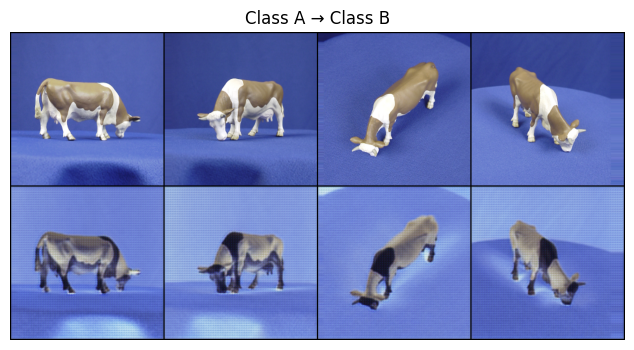

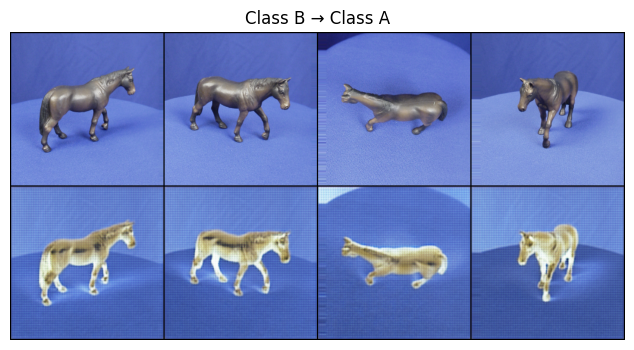

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Generator (Simple CNN)
# ----------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# ----------------------------
# Discriminator (Simple CNN)
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# ----------------------------
# Data Loader (with 2 classes)
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder("dataset/Train", transform=transform)
class_indices = dataset.class_to_idx
print("Classes found:", class_indices)

# split by labels
class_a_idx = [i for i, (_, label) in enumerate(dataset.samples) if label == 0]
class_b_idx = [i for i, (_, label) in enumerate(dataset.samples) if label == 1]

from torch.utils.data import Subset
loader_a = DataLoader(Subset(dataset, class_a_idx), batch_size=4, shuffle=True)
loader_b = DataLoader(Subset(dataset, class_b_idx), batch_size=4, shuffle=True)

# ----------------------------
# Models & Optimizers
# ----------------------------
G_a2b = Generator().to(device)
G_b2a = Generator().to(device)
D_a = Discriminator().to(device)
D_b = Discriminator().to(device)

g_optimizer = optim.Adam(itertools.chain(G_a2b.parameters(), G_b2a.parameters()), lr=0.0002)
d_optimizer = optim.Adam(itertools.chain(D_a.parameters(), D_b.parameters()), lr=0.0002)

loss_GAN = nn.BCELoss()
loss_cycle = nn.L1Loss()
epochs=200

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(epochs):
    for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
        real_a = real_a.to(device)
        real_b = real_b.to(device)
        # Get valid/fake label size based on D output
        with torch.no_grad():
            temp_out = D_a(real_a)
            valid = torch.ones_like(temp_out)
            fake = torch.zeros_like(temp_out)
            
        # ----------------------
        # Train Generators
        # ----------------------
        g_optimizer.zero_grad()

        fake_b = G_a2b(real_a)
        rec_a = G_b2a(fake_b)
        loss_cyc_a = loss_cycle(rec_a, real_a)

        fake_a = G_b2a(real_b)
        rec_b = G_a2b(fake_a)
        loss_cyc_b = loss_cycle(rec_b, real_b)

        loss_g = loss_GAN(D_b(fake_b), valid) + loss_GAN(D_a(fake_a), valid)
        loss_g_total = loss_g + 10 * (loss_cyc_a + loss_cyc_b)
        loss_g_total.backward()
        g_optimizer.step()

        # ----------------------
        # Train Discriminators
        # ----------------------
        d_optimizer.zero_grad()
        loss_d_a = (loss_GAN(D_a(real_a), valid) + loss_GAN(D_a(fake_a.detach()), fake)) * 0.5
        loss_d_b = (loss_GAN(D_b(real_b), valid) + loss_GAN(D_b(fake_b.detach()), fake)) * 0.5
        loss_d = loss_d_a + loss_d_b
        loss_d.backward()
        d_optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | G Loss: {loss_g_total.item():.4f} | D Loss: {loss_d.item():.4f}")

# ----------------------------
# Show Translated Images
# ----------------------------
def show_samples(input_imgs, translated_imgs, title):
    imgs = torch.cat((input_imgs, translated_imgs), 0).detach().cpu()
    imgs = imgs * 0.5 + 0.5
    grid = utils.make_grid(imgs, nrow=4)
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.axis("off")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

G_a2b.eval()
G_b2a.eval()
with torch.no_grad():
    real_a = next(iter(loader_a))[0].to(device)
    real_b = next(iter(loader_b))[0].to(device)
    fake_b = G_a2b(real_a)
    fake_a = G_b2a(real_b)
    show_samples(real_a, fake_b, "Class A → Class B")
    show_samples(real_b, fake_a, "Class B → Class A")
